In [1]:
import numpy as np
from obspy.core import Stream
from obspy import UTCDateTime
from obspy.signal.rotate import rotate_ne_rt
from telewavesim import utils as ut
from telewavesim import wiggle as wg
import os

In [2]:
modfile = './model_GOAM/27_model.txt'
wvtype = 'SV'
# timedir=f'20220301_135224'

In [3]:
npts = 3600 # Number of samples
dt = 0.05   # Sample distance in seconds

In [4]:
slow = 0.04 # Horizontal slowness (or ray parameter) in s/km 
baz = np.arange(0,360,10)

In [6]:
model = ut.read_model(modfile)

In [7]:
t1 = ut.calc_ttime(model, slow, wvtype=wvtype)
print('Predicted propagation time from model: {0:4.1f} sec'.format(t1))

Predicted propagation time from model: 63.7 sec


In [8]:
trR = Stream(); trT = Stream()

In [9]:
nowtime = UTCDateTime()+8*3600
timedir = f'{nowtime.year}{str(nowtime.month).zfill(2)}{str(nowtime.day).zfill(2)}_{str(nowtime.hour).zfill(2)}{str(nowtime.minute).zfill(2)}{str(nowtime.second).zfill(2)}'
# Loop over range of data 
for bb in baz:
    # Calculate the plane wave seismograms
    trxyz = ut.run_plane(model, slow, npts, dt, bb, wvtype=wvtype)
    # Creat dir to save trace 
    TraceDir = f'Model_mseed/{timedir}/Baz_{int(bb)}'
    if not os.path.isdir(TraceDir):
        os.makedirs(TraceDir)
    # Extract East, North and Vertical
    trxyz[0].stats.starttime = UTCDateTime(timedir)
    trxyz[1].stats.starttime = UTCDateTime(timedir)
    trxyz[2].stats.starttime = UTCDateTime(timedir)
    ntr = trxyz[0]
    etr = trxyz[1]
    ztr = trxyz[2]
    ntr.write(f'{TraceDir}/XX.MOD..HHN.mseed', format="MSEED")
    etr.write(f'{TraceDir}/XX.MOD..HHE.mseed', format="MSEED")
    ztr.write(f'{TraceDir}/XX.MOD..HHZ.mseed', format="MSEED")
    # Copy to radial and transverse
    rtr = ntr.copy()
    ttr = etr.copy()

    # Rotate to radial and transverse
    rtr.data, ttr.data = rotate_ne_rt(ntr.data, etr.data, bb)

    # Append to streams
    trR.append(rtr)
    trT.append(ttr)

/Users/tong/opt/anaconda3/envs/tws/lib/python3.7/site-packages/obspy/io/mseed/core.py:715: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)


In [10]:
# Set frequency corners in Hz
f1 = 0.05
f2 = 0.125

# Filter to get wave-like traces
trR.filter('bandpass',freqmin=f1, freqmax=f2, corners=2, zerophase=True)
trT.filter('bandpass',freqmin=f1, freqmax=f2, corners=2, zerophase=True)

36 Trace(s) in Stream:

XX.MOD..HHE | 2022-03-28T16:17:24.000000Z - 2022-03-28T16:20:23.950000Z | 20.0 Hz, 3600 samples
...
(34 other traces)
...
XX.MOD..HHE | 2022-03-28T16:17:24.000000Z - 2022-03-28T16:20:23.950000Z | 20.0 Hz, 3600 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


Plotting Wiggles by baz


0

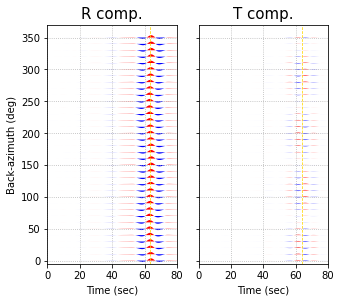

In [12]:
# Plot as wiggles
wg.pw_wiggles_baz(trR, trT, 'test', btyp='baz', scale=0.05,
                  t1=t1, tmin=0., tmax=80, save=True,
                  ftitle='sks', wvtype='SV')
cmd = '''mv sks.png Model_mseed/%(timedir)s''' % locals()
os.system(cmd)